## Importación de Librerías

Comenzaremos importando las librerías necesarias para nuestro análisis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from wordcloud import WordCloud
from transformers import pipeline
from collections import defaultdict

C:\Users\ikera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga de Datos

Cargamos los datos desde el archivo CSV en un DataFrame de pandas.

In [2]:
data = pd.read_csv("dataset/top_items_reviews.csv")

## División de DataFrame

Divideremos el DataFrame en uno de películas y otro de series

In [3]:
# Dividir el DataFrame en dos: uno para películas y otro para series
movies_df = data[data['type'] == 'movie']
tvshows_df = data[data['type'] == 'tvshow']

# Mostrar las primeras filas de cada DataFrame para verificar
movies_df_titles = movies_df["title"]
tvshows_df_titles = tvshows_df["title"]

# Mostrar los títulos de las películas
print("Películas a elegir:")
for index, title in enumerate(movies_df_titles):
    print(f"{index}. {title}")

# Mostrar los títulos de las series
print("\nSeries a elegir:")
for index, title in enumerate(tvshows_df_titles):
    print(f"{index}. {title}")



Películas a elegir:
0. Renaissance: A Film by Beyoncé
1. Oppenheimer
2. All of Us Strangers
3. Past Lives
4. Perfect Days

Series a elegir:
0. Beef
1. White House Plumbers
2. American Born Chinese
3. One Piece (2023)
4. Lessons in Chemistry


## Selección de Película y Serie
Seleccionaremos la película y la serie de la que busquemos realizar el análisis de datos. Para esta elección tendrás que cambiar el número que aparece en el iloc, mediante los índices dados en el apartado de arriba.

In [9]:
# Seleccionando la primera película del DataFrame de películas para el análisis
selected_movie = movies_df.iloc[1]

# Seleccionando la primera serie del DataFrame de series para el análisis
selected_tvshow = tvshows_df.iloc[3]

# Mostrar la información de la película seleccionada
selected_movie_info = selected_movie[['title', 'release_date', 'genres', 'user_reviews', 'critic_reviews']]
print(selected_movie_info)

print("\n")

# Mostrar la información de la serie seleccionada
selected_tvshow_info = selected_tvshow[['title', 'release_date', 'genres', 'user_reviews', 'critic_reviews']]
print(selected_tvshow_info)

title                                                   Oppenheimer
release_date                                             2023-07-21
genres                            {'Drama', 'History', 'Biography'}
user_reviews      [('9', "A great movie! The writing, art, music...
critic_reviews    [(10.0, 'It’s powerful, a technically dazzling...
Name: 1, dtype: object


title                                              One Piece (2023)
release_date                                             2023-08-31
genres            {'Fantasy', 'Drama', 'Comedy', 'Action', 'Adve...
user_reviews      [('9', 'As someone who has watched the one pie...
critic_reviews    [(9.1, 'The series does very well at remaining...
Name: 8, dtype: object


## Wordcloud

Primero definimos el método que generará la wordcloud, de manera que podremos usarlo tanto para diferentes reseñas (críticas y de usuarios), como diferentes items (películas y series)


In [10]:

# Función para generar un wordcloud a partir de las reseñas
def generate_wordcloud(reviews,title):
    text = " ".join([review for score, review in reviews])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap="viridis",contour_color="steelblue").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20, fontweight='bold', pad=30)
    plt.axis('off')
    plt.show()



Procedemos a generar las wordcloud para la película y la serie

# Pelicula

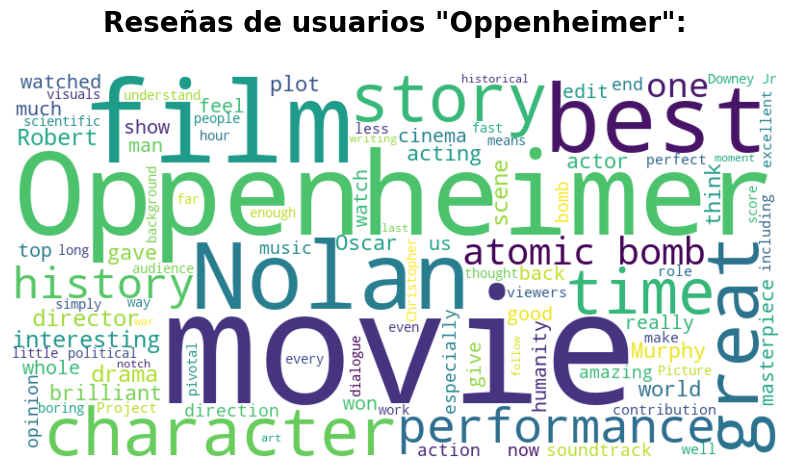

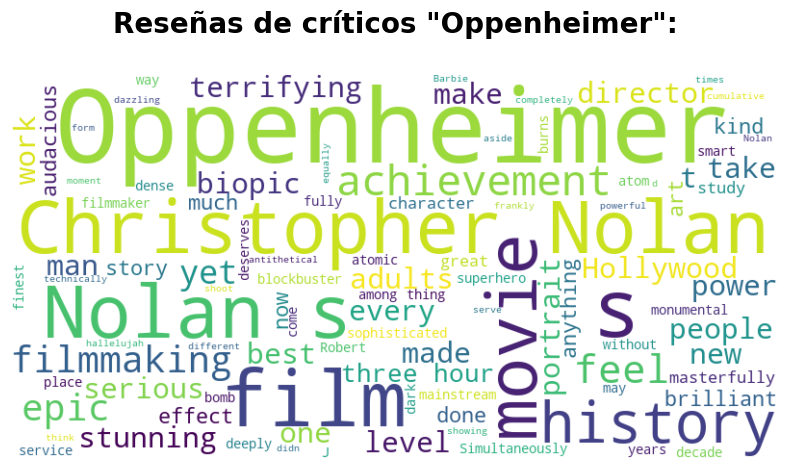

In [11]:

# Preprocesamiento y análisis de las reseñas de usuarios y críticos
user_reviews_movie = ast.literal_eval(selected_movie['user_reviews'])
critic_reviews_movie = ast.literal_eval(selected_movie['critic_reviews'])

# Generar y mostrar wordcloud para las reseñas de usuarios
generate_wordcloud(user_reviews_movie, f"Reseñas de usuarios \"{selected_movie['title']}\":")

# Generar y mostrar wordcloud para las reseñas de críticos
generate_wordcloud(critic_reviews_movie, f"Reseñas de críticos \"{selected_movie['title']}\":")

# Serie

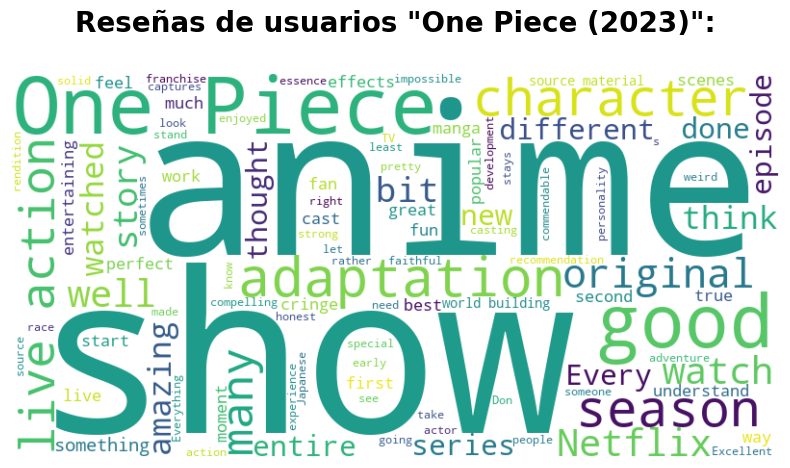

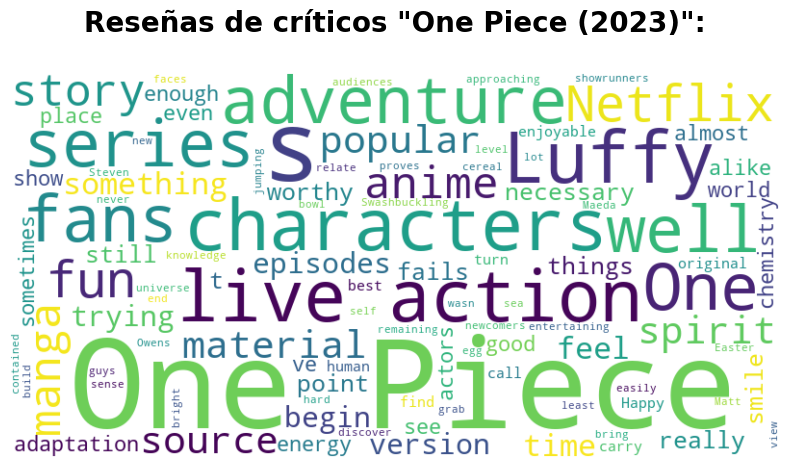

In [12]:
# Preprocesamiento y análisis de las reseñas de usuarios y críticos
user_reviews_tvshow = ast.literal_eval(selected_tvshow['user_reviews'])
critic_reviews_tvshow = ast.literal_eval(selected_tvshow['critic_reviews'])

# Generar y mostrar wordcloud para las reseñas de usuarios
generate_wordcloud(user_reviews_tvshow, f"Reseñas de usuarios \"{selected_tvshow['title']}\":")

# Generar y mostrar wordcloud para las reseñas de críticos
generate_wordcloud(critic_reviews_tvshow, f"Reseñas de críticos \"{selected_tvshow['title']}\":")

In [13]:
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)
movie_output = []
tvshows_output = []

for _,user_review in user_reviews_movie:
    classifier_output = classifier(user_review)
    movie_output.append((int(_),user_review, classifier_output[0]))
    
for _,critic_review in critic_reviews_movie:
    classifier_output = classifier(critic_review)
    movie_output.append((int(_),critic_review, classifier_output[0]))
    
for _,user_review in user_reviews_tvshow:
    classifier_output = classifier(user_review)
    tvshows_output.append((int(_),user_review, classifier_output[0]))
    
for _,critic_review in critic_reviews_tvshow:
    classifier_output = classifier(critic_review)
    tvshows_output.append((int(_),critic_review, classifier_output[0]))

In [14]:
# Inicializar variables para análisis
total_score = 0
sentiment_scores = defaultdict(float)
num_reviews = len(movie_output)

# Procesamiento de cada tupla
for score, review, sentiments in movie_output:
    total_score += score

    # Sumar los puntajes de los sentimientos
    for sentiment in sentiments:
        sentiment_scores[sentiment['label']] += sentiment['score']

# Calcular promedio de puntuaciones
average_score = total_score / num_reviews

# Calcular promedio de puntuaciones de sentimientos
for sentiment in sentiment_scores:
    sentiment_scores[sentiment] /= num_reviews

# Ordenar y obtener los sentimientos más comunes
sorted_sentiments = sorted(sentiment_scores.items(), key=lambda x: x[1], reverse=True)
top_sentiments = sorted_sentiments[:5]  # Ajustar la cantidad según sea necesario

# Mostrar resultados
print(f"Titulo: {selected_movie['title']}")
print(f"Total de Reseñas: {num_reviews}")
print(f"Promedio de Calificación: {average_score:.2f}")
print("Sentimientos Principales y sus Promedios:")
for sentiment, avg_score in top_sentiments:
    print(f"  {sentiment}: {avg_score:.2f}")


Titulo: Oppenheimer
Total de Reseñas: 60
Promedio de Calificación: 8.58
Sentimientos Principales y sus Promedios:
  admiration: 0.57
  neutral: 0.21
  approval: 0.11
  disappointment: 0.06
  disapproval: 0.04


In [15]:
total_score = 0
sentiment_scores = defaultdict(float)
num_reviews = len(tvshows_output)

# Procesamiento de cada tupla
for score, review, sentiments in tvshows_output:
    total_score += score

    # Sumar los puntajes de los sentimientos
    for sentiment in sentiments:
        sentiment_scores[sentiment['label']] += sentiment['score']

# Calcular promedio de puntuaciones
average_score = total_score / num_reviews

# Calcular promedio de puntuaciones de sentimientos
for sentiment in sentiment_scores:
    sentiment_scores[sentiment] /= num_reviews

# Ordenar y obtener los sentimientos más comunes
sorted_sentiments = sorted(sentiment_scores.items(), key=lambda x: x[1], reverse=True)
top_sentiments = sorted_sentiments[:5]  # Ajustar la cantidad según sea necesario

# Mostrar resultados
print(f"Titulo: {selected_tvshow['title']}")
print(f"Total de Reseñas: {num_reviews}")
print(f"Promedio de Calificación: {average_score:.2f}")
print("Sentimientos Principales y sus Promedios:")
for sentiment, avg_score in top_sentiments:
    print(f"  {sentiment}: {avg_score:.2f}")

Titulo: One Piece (2023)
Total de Reseñas: 52
Promedio de Calificación: 7.15
Sentimientos Principales y sus Promedios:
  admiration: 0.36
  neutral: 0.20
  approval: 0.17
  joy: 0.12
  disapproval: 0.04
